# Imports

In [7]:

import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from matplotlib import pyplot as plt
h2o.init()



Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 min 27 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_hansstem_h12su5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.765 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


# Load datasets

In [8]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()



# Data clean up

In [33]:
# making shure that target values line up with x_values
import data_func.combine_all_frames as CAF

def data_allign(x_train, y_train):
  
  y_train.dropna(inplace=True)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' in combined_data.columns:
    combined_data.drop(columns=['time'], inplace=True)
    
  return combined_data, y_train

import data_func.aggregation as data_agg

categorical_features = ['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'precip_type_5min:idx', 'snow_drift:idx']

# for i in range(len(X_frames_train)):

#   X_frames_train[i] = data_agg.gen_agg(X_frames_train[i], 'mean')
#   X_frames_train[i], Y_frames_train[i] = data_allign(X_frames_train[i], Y_frames_train[i])

# for j in range(len(X_frames_test)):
#     X_frames_test[j] = data_agg.gen_agg(X_frames_test[j], 'mean')

X_frames_train_pd = CAF.combine_all_frames(X_frames_train)
X_frames_test_pd = CAF.combine_all_frames(X_frames_test)
Y_frames_train_pd = pd.concat(Y_frames_train, ignore_index=True)

X_frames_train_pd, Y_frames_train_pd = data_allign(X_frames_train_pd, Y_frames_train_pd)

print(X_frames_test_pd.shape)

X_frames_train_pd = data_agg.gen_agg(X_frames_train_pd, 'mean')
X_frames_test_pd = data_agg.gen_agg(X_frames_test_pd, 'mean')



(8640, 56)


In [10]:
import data_func.timeseasonality as DTS
import data_func.date_forecast as DTF
import data_func.combine_all_frames as CAF
import data_func.one_hot_encoding as OHE

for i in range(len(X_frames_train)):
    X_frames_train[i] = DTS.append_seasonal_columns(X_frames_train[i])
    X_frames_train[i] = DTF.date_forecast_columns(X_frames_train[i])
    # X_frames_train[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True)
    # X_frames_train[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    # X_frames_train[i]['ceiling_height_agl:m'] = X_frames_train[i]['ceiling_height_agl:m'].fillna(0)
    # X_frames_train[i]['cloud_base_agl:m'] = X_frames_train[i]['cloud_base_agl:m'].fillna(100000)

# X_frames_train_pd = CAF.combine_all_frames(X_frames_train)
X_frames_train_pd = OHE.one_hot_encode(X_frames_train_pd, ["location"])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DTF.date_forecast_columns(X_frames_test[i])

# X_frames_test_pd = CAF.combine_all_frames(X_frames_test)
X_frames_test_pd = OHE.one_hot_encode(X_frames_test_pd, ["location"])

# Y_frames_train_pd = CAF.combine_all_frames(Y_frames_train)
# Y_frames_train_pd = pd.concat(Y_frames_train, ignore_index=True)

# print(X_frames_train[0]['ceiling_height_agl:m'].isnull().sum())
# X_frames_train_pd = pd.merge(X_frames_train_pd, Y_frames_train_pd, left_on='date_forecast', right_on='time')

# Feature engineering

In [24]:

# Data set A, B and C to H2O
def data_to_h2o_one_frame(dataframe):
    return h2o.H2OFrame(dataframe)


def data_to_h2o(x_train, y_train, x_test):
  
    x_train_h2o = h2o.H2OFrame(x_train)
    y_train = y_train.to_frame()
    y_train_h2o = h2o.H2OFrame(y_train)
    x_test_h2o = h2o.H2OFrame(x_test)
  
    return x_train_h2o, y_train_h2o, x_test_h2o

x_train_combined_h2o = data_to_h2o_one_frame(X_frames_train_pd)
x_test_combined_h2o = data_to_h2o_one_frame(X_frames_test_pd)
y_train_combined_h2o = data_to_h2o_one_frame(Y_frames_train_pd.to_frame())

# x_train_a_h2o, y_train_a_h2o, x_test_a_h2o = data_to_h2o(x_train_a, y_train_a, X_test_estimated_a)
# x_train_b_h2o, y_train_b_h2o, x_test_b_h2o = data_to_h2o(x_train_b, y_train_b, X_test_estimated_b)
# x_train_c_h2o, y_train_c_h2o, x_test_c_h2o = data_to_h2o(x_train_c, y_train_c, X_test_estimated_c)
y_train_combined_h2o.shape
x_train_combined_h2o.shape


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


(66732, 56)

# Training the model

In [12]:
# print(y_train_a_h2o)
# aml_a = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)
# aml_b = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)
# aml_c = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)
aml_combined = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)

# aml_a.train(x=x_train_a_h2o.columns, y=y_train_a_h2o.columns[0], training_frame=x_train_a_h2o)
# aml_b.train(x=x_train_b_h2o.columns, y=y_train_b_h2o.columns[0], training_frame=x_train_b_h2o)
# aml_c.train(x=x_train_c_h2o.columns, y=y_train_c_h2o.columns[0], training_frame=x_train_c_h2o)
aml_combined.train(x=x_train_combined_h2o.columns, y=y_train_combined_h2o.columns[0], training_frame=x_train_combined_h2o)

AutoML progress: |
14:34:22.813: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/10
# GBM base models (used / total),4/6
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


# Evaluate training

In [18]:
lb = aml_combined.leaderboard
lb.head(rows=lb.nrows) 


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20231025_143422,126.299,15951.5,52.9818,nan,15951.5
StackedEnsemble_BestOfFamily_1_AutoML_1_20231025_143422,129.874,16867.4,55.4083,nan,16867.4
GBM_3_AutoML_1_20231025_143422,130.012,16903.1,55.2314,nan,16903.1
GBM_4_AutoML_1_20231025_143422,130.128,16933.4,53.4884,nan,16933.4
GBM_2_AutoML_1_20231025_143422,133.073,17708.4,57.4469,nan,17708.4
GBM_1_AutoML_1_20231025_143422,137.4,18878.9,59.4145,nan,18878.9
GBM_5_AutoML_1_20231025_143422,139.206,19378.4,61.1338,nan,19378.4
GBM_grid_1_AutoML_1_20231025_143422_model_1,150.405,22621.7,63.6347,nan,22621.7
DRF_1_AutoML_1_20231025_143422,172.485,29751.2,72.6512,0.771335,29751.2
XRT_1_AutoML_1_20231025_143422,175.309,30733.3,74.788,0.834331,30733.3


# Make predictions

In [21]:
# y_pred_a = aml_a.leader.predict(x_test_a_h2o)
# y_pred_b = aml_b.leader.predict(x_test_b_h2o)
# y_pred_c = aml_c.leader.predict(x_test_c_h2o)

# y_pred_a = y_pred_a.as_data_frame()
# y_pred_b = y_pred_b.as_data_frame()
# y_pred_c = y_pred_c.as_data_frame()
y_pred_combined = aml_combined.leader.predict(x_test_combined_h2o)
y_pred = y_pred_combined.as_data_frame()

# y_pred = pd.concat([y_pred_a, y_pred_b, y_pred_c], axis=0, ignore_index=True)
y_pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/hansstem/.conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'location_0.0': substituting in a column of NaN
  warnings.warn(w)
/Users/hansstem/.conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'location_0.25': substituting in a column of NaN
  warnings.warn(w)
/Users/hansstem/.conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'location_0.5': substituting in a column of NaN
  warnings.warn(w)
/Users/hansstem/.conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'location_0.75': substituting in a column of NaN
  warnings.warn(w)
/Users/hansstem/.conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'location_1.25': substituting in a column of NaN
  warnings.warn(w)
/Users/hansstem/.conda/lib/python3.10/site-packages/

,predict
0,-3.578823
1,-4.195656
2,2.080455
3,63.146748
4,287.702733


# Create submission

(720, 1)

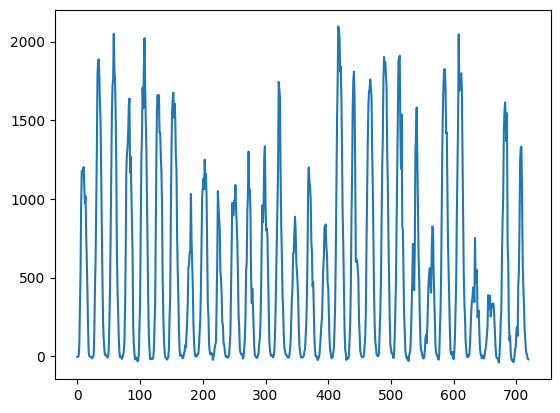

In [20]:
plt.plot(y_pred)
y_pred.shape

In [ ]:
test = pd.read_csv('../data/test.csv')
test['prediction'] = y_pred['predict']
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)